In [1]:
import os
import numpy as np
import pandas as pd
import netCDF4 as nc
import datetime
import seaborn as sns

from scipy.io import savemat

In [2]:
#date_time_str = '2018-06-29 08:15:27.243860'
#date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')

#date_time_str = '20170822.2100'
#date_time_obj = datetime.datetime.strptime(date_time_str, '%Y%m%d.%H%M')
#dates = [datetime.datetime.strptime(f, '%Y%m%d.%H%M')]


#print('Date:', date_time_obj.date())
#print('Time:', date_time_obj.time())
#print('Date-time:', date_time_obj)

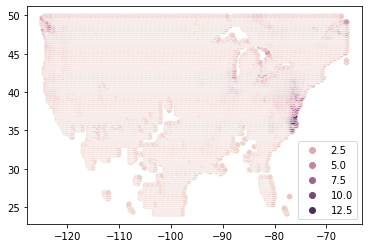

In [27]:
na_value = -999

#var ='Qsb_acc'
var = 'Qs_acc'

hur_name = 'Sandy'
time_zone = 0;
    
root_dir = '/home/cuincie/Precipitation/Data'
indir = os.path.join(root_dir,hur_name)

files = os.listdir(indir)
files = [f for f in files if ('nc4' in f) ]
# get the times of each file
time_strings = [f[18:31] for f in files]
times = [datetime.datetime.strptime(f, '%Y%m%d.%H%M') for f in time_strings]
dummy = np.array(times)
a1 = int(np.abs(time_zone))
b1 = np.sign(time_zone)
local_times = dummy + b1*datetime.timedelta(hours=a1)

df = pd.DataFrame(columns=['Filename','Local_Time'])

df['Local_Time'] = local_times
df['Filename'] = files
df['Year'] = pd.DatetimeIndex(df['Local_Time']).year
df['Month'] = pd.DatetimeIndex(df['Local_Time']).month
df['Day'] = pd.DatetimeIndex(df['Local_Time']).day
df = df.sort_values(by='Local_Time',ignore_index=True)

infile = os.path.join(indir,df.Filename[0])
ds = nc.Dataset(infile)
lon = ds['lon'][:]
lat = ds['lat'][:]
lat_idx = np.where((lat>24) & (lat<50))
lon_idx = np.where((lon>-125) & (lon<-66))

lat_grid = np.tile(np.array(lat[lat_idx]), (236, 1)).transpose().reshape(-1)
lon_grid = np.tile(np.array(lon[lon_idx]), (104, 1)).reshape(-1)

num_days = (df.iloc[-1,1] - df.iloc[0,1]).days
data_acc = np.zeros([num_days,len(lat_grid)])

data = ds[var][0,lat_idx[0][0]:lat_idx[0][-1]+1,lon_idx[0][0]:lon_idx[0][-1]+1]
data = data.reshape(-1)
data_acc[0,:]= data

day0 = df.Day[0]
day_idx = 0


for idx, row in df.iloc[1:,:].iterrows():
    infile = os.path.join(indir,row.Filename)
    ds = nc.Dataset(infile)
    data = ds[var][0,lat_idx[0][0]:lat_idx[0][-1]+1,lon_idx[0][0]:lon_idx[0][-1]+1]
    data = data.reshape(-1)

    if row['Day'] == day0:
        data_acc[day_idx,:] = data_acc[day_idx,:]+data
    else:
        day0 = row['Day']
        day_idx = day_idx+1
        try:
            data_acc[day_idx,:] = data_acc[day_idx,:]+data
        except:
            data_acc = np.vstack([data_acc,data])



daily_data = data_acc
daily_max_data = daily_data.max(axis=0)
sum_data = daily_data.sum(axis=0)

# set fill value for daily_max_data
np.ma.set_fill_value(daily_max_data,na_value)

# remask the sum_data so that invalid cells have value -999
a = np.ma.getdata(sum_data)
a[a<0] = na_value
a = np.ma.masked_where(a<0,a)
np.ma.set_fill_value(a,na_value)
sum_data = a.copy()

# remask the daily_data so that invalid cells have value -999
a=np.ma.getdata(daily_data)
a[a<0] = na_value
a = np.ma.masked_where((a<0), a)
np.ma.set_fill_value(a,na_value)
daily_data = a.copy()

daily_data_value = np.ma.getdata(daily_data)
sum_data_value = np.ma.getdata(sum_data)



if var =='Qsb_acc':
    filename = hur_name+ '_'+ str(df.Year[0]) + '_Baseflow_Groundwater_Runoff.mat'
elif var =='Qs_acc':
    filename = hur_name+ '_'+ str(df.Year[0]) + '_Storm_Surface_Runoff.mat'

ofile = os.path.join(root_dir,filename)
mdic = {"gldas_daily_data": daily_data,'gldas_daily_max_data':daily_max_data, "gldas_sum_data": sum_data, \
        "gldas_unit":"mm", "gldas_lat": lat_grid, "gldas_lon":lon_grid,'gldas_time_zone':time_zone, \
        'gInvaid':na_value}
savemat(ofile, mdic)

idx = daily_max_data>0
ax=sns.scatterplot(x=lon_grid[idx],y=lat_grid[idx],hue=daily_max_data[idx])
#ax.set_xlim([-95,-70])
#ax.set_ylim([25,55])